# TP 2 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

   Resolving package versions...


  No Changes to `C:\Users\offic\OneDrive\Bureau\tp2\Project.toml`
  No Changes to `C:\Users\offic\OneDrive\Bureau\tp2\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\offic\OneDrive\Bureau\tp2\Project.toml`
  No Changes to `C:\Users\offic\OneDrive\Bureau\tp2\Manifest.toml`


### Récupération des données

In [2]:
function readKnaptxtInstance(filename)
    price=Int64[]
    weight=Int64[]
    KnapCap=Int64[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [3]:
function testSondability_LP( capacity,  borne, BestProfit, Bestsol)
   
    TA, TO, TR = false, false, false
    
    

    if capacity < 0  # Test d'Admissibilité
        TA = true
        
        println("TA")
        
    elseif (borne < BestProfit)  # Test d'optimalite
        TO = true
        
        println("TO")
        
    elseif (capacity == 0) || (borne == BestProfit)  # Test de resolution
        TR = true
        
        println("TR")
       
        
    else
        
        println("non sondable")
        
    end
    return TA, TO, TR, Bestsol, BestProfit
end

testSondability_LP (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [4]:
function separateNodeThenchooseNext_lexicographic_depthfirst!(listobjs, listvals, n)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node at the left

    # lexicographic branching criterion: branch on the 1st object not yet fixed
    i, obj = 1, 0
    while((i <= n) && (obj==0))
        if(!(i in listobjs))
            obj=i
        end
        i+=1
    end

    println("\nbranch on object ", obj, "\n")

    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listobjs,obj) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
end


function exploreNextNode_depthfirst!(listobjs, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible

    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
        end
        if theval==1.0
            push!(listobjs,obj)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    return stop
end

exploreNextNode_depthfirst! (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0):

In [5]:
function Bornes(price, weight, capacity, listobjs, listvals, BestProfit, Bestsol, option)
    
    borne = 0
    prix = 0
    max = 0

    if option == 1
        weightAct = 0
        priceAct = 0
        for i in 1:length(listobjs)
            if listvals[i] == 1
                if weightAct + weight[listobjs[i]] <= capacity
                    weightAct += weight[listobjs[i]]
                    priceAct += price[listobjs[i]]
                end
            end 
        end
    
        if priceAct >= BestProfit
            Bestsol = copy(listobjs)
            BestProfit = priceAct
        end
            
        if (length(listobjs) < length(price)) 
            for i in (length(listobjs)+1):length(price)
                r = price[i]/weight[i]
                if (!(i in listobjs)) 
                    if r > max        
                        max = r
                    end     
                end
            end
            borne = prix + max*capacity
        else
            borne = prix
        end
        
    elseif option == 2
        for i in 1:length(listobjs)
            if listvals[i] == 1
                capacity = capacity - weight[listobjs[i]]
                println("Capacity = ", capacity)
                prix = prix + price[listobjs[i]]
                
            end
        end
    
        deleteat!(price, listobjs)
        deleteat!(weight, listobjs)
    
        if capacity >= 0
            if prix > BestProfit
                BestProfit = prix
                Bestsol = copy(listobjs)
            end
        end
        
        
        # Ratio
        r = price./weight
        listR = [(r[i], weight[i]) for i in 1:length(price)]
        listR = sort(listR, by = x -> x[1], rev=true)
        prix1 = 0

        for i in 1:length(listR)
            if listR[i][2] <= capacity
                prix1 = prix1 + listR[i][1]*listR[i][2]
                capacity = capacity - listR[i][2]
            else
                break
            end
        end

        borne = prix + prix1
    end

return borne, capacity, BestProfit, Bestsol

end

Bornes (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [6]:
function solveKnapInstance(filename, option)

    price, weight, capacity = readKnaptxtInstance(filename)
    n = length(price)

    #model2, x = createModel_LP(price, weight, capacity)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=Int64[]
    listvals=Float64[]
    listnodes=Int64[]

    BestProfit::Float64=-1.0
    Bestsol=Float64[]

    current_node_number::Int64=0
    stop = false

    while(!stop)

        println("\nNode number ", current_node_number, " : \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)

        
        #create LP of current node
        #updateModele_LP!(model2, x, listobjs, listvals)
        
        #println(model2)
        
        print("Solve the LP model of the current node to compute its bound: start ...\n\n")

        #status = optimize!(model2)

        
        priceAct = deepcopy(price)
        weightAct = deepcopy(weight)
        capacityAct = capacity
        
        borne, capacityAc, Bestp, BestS = Bornes(priceAct, weightAct, capacityAct, listobjs,listvals, BestProfit, Bestsol, option)

        BestProfit = Bestp

        Bestsol = BestS



        TA, TO, TR = testSondability_LP( capacityAc,  borne, Bestp, BestS)

        is_node_sondable = TA || TO || TR

        #Reset_LP!(model2, x, listobjs)

        if(!is_node_sondable)
            separateNodeThenchooseNext_lexicographic_depthfirst!(listobjs, listvals, length(price))
        else
            stop = exploreNextNode_depthfirst!(listobjs, listvals, listnodes)
        end
        
        #resetAll_LP!(model2, x)

        current_node_number = current_node_number + 1
    end

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x = ", Bestsol)

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


solveKnapInstance (generic function with 1 method)

### Affichage du résultat final

In [7]:
function solveNdisplayKnap(filename)

    println("\nBranch-and-Bound for solving a knapsack problem. \n\nSolving instance '" * filename * "'\n")

    # Option 1
    println("***** using option 1 *****")
    BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = @time solveKnapInstance(filename, 1)
    
    # Affichage de l'arbre
    println("\n Branch-and-bound tree visualization : start display ...")
    display(graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree))
    println("... end display. \n\n")

    println("-----------------------------------------------\n")

    # Option 2
    println("***** using option 2 *****")
    BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = @time solveKnapInstance(filename, 2)

    # Affichage de l'arbre
    println("\n Branch-and-bound tree visualization : start display ...")
    display(graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree))
    println("... end display. \n\n")

end

solveNdisplayKnap (generic function with 1 method)


Branch-and-Bound for solving a knapsack problem. 

Solving instance 'InstancesKnapSack/test.opb.txt'

***** using option 1 *****

Node number 0 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1


Node number 1 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2


Node number 2 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3


Node number 3 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

TO

Node number 4 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



TO

Node number 5 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

TO

Node number 6 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2


Node number 7 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

TO

Node number 8 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

TO

FINISHED

******

Optimal value = 54.0

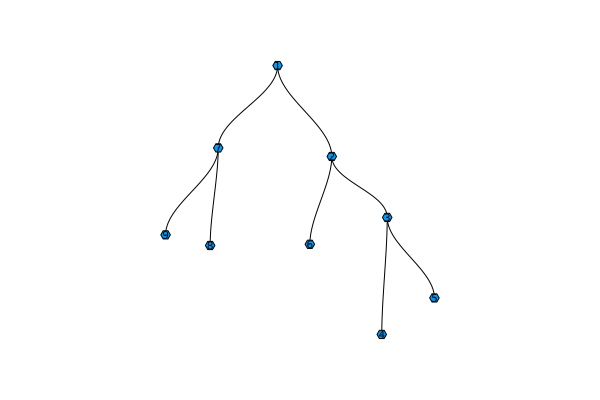



Optimal x = [1, 2, 3]
  0.287038 seconds (163.37 k allocations: 11.170 MiB, 76.27% compilation time)

 Branch-and-bound tree visualization : start display ...


... end display. 


-----------------------------------------------

***** using option 2 *****

Node number 0 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1


Node number 1 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

Capacity = 3
TR

Node number 2

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2


Node number 3 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

Capacity = 6
non sondable

branch on object 3


Node number 4 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

Capacity = 6
Capacity = 3
TR

Node number 5 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

Capacity = 6
non sondable

branch on object 4


Node number 6 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

Capacity = 6
Capacity = 1


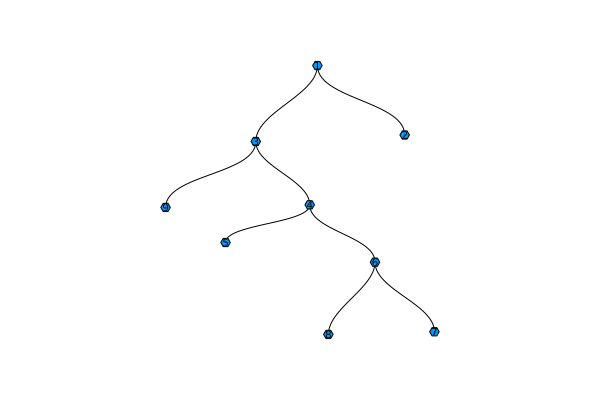

TR

Node number 7 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

Capacity = 6
TO

Node number 8 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

TO

FINISHED

******

Optimal value = 65.0

Optimal x = [1, 2, 3, 4]
  0.790582 seconds (563.65 k allocations: 37.658 MiB, 76.11% compilation time)

 Branch-and-bound tree visualization : start display ...
... end display. 


press enter to exit ! 


In [8]:
INSTANCE = "InstancesKnapSack/test.opb.txt"
solveNdisplayKnap(INSTANCE)
println("press enter to exit ! ")


### Questions préliminaires

Q1 - La règle de séparation sélectionnée est la règle lexicographique, où le choix se fait en accord avec l'ordre lexicographique des objets. Plus spécifiquement, cela signifie qu'on choisit le premier objet qui n'a pas encore été inclus dans la solution.

Q2 - La borne supérieure est déterminée en résolvant la relaxation linéaire du problème. Ce processus implique la fixation des variables à 1 pour les objets inclus dans la solution et à 0 pour ceux qui ne le sont pas.

Q3 -

- TA : Admissible si la relaxation linéaire a une solution.
- TO : La relaxation linéaire est inférieur profit maximal.
- TR : La relaxation linéaire atteinte par valeurs entières.

Q4 - La méthode d'exploration adoptée est la stratégie de recherche en profondeur, souvent désignée par le terme "depthfirst".

### Code et Analyses

Q1 / Q2 - Voir la fonction Bornes.

Q3 - 

- Règle de Séparation : Nous avons maintenu l'ordre lexicographique initial dans notre implémentation du Branch-and-Bound.
- Test de Faisabilité (TA) : Le test  est réussi lorsque la capacité du sac à dos devient négative. c'est à dire le sac est remplie plus que sa capacité normal.
- Test d'Optimalité (TO) : Le test réussit si la valeur de la borne supérieure, obtenue en remplissant le sac à dos, est inférieure à la meilleure solution déjà identifiée.
- Test de Relaxation (TR) : Le test de relaxation est réussi lorsque nous identifions une solution évidente au problème. Nous l'avons validé en cas de capacité nulle du sac à dos au nœud sondé, ou on trouve la même solution qu'on a trouvé avant.
- Stratégie d'Exploration : Nous avons conservé la stratégie d'exploration en profondeur (deephtfirst) .

Q4 - 

- Calcul de la borne supérieure (fonction Bornes): Deux bornes supérieures sont calculées en fonction de l'option choisie. L'option 1 utilise une approche gloutonne basée sur la capacité restante et le ratio prix/poids, tandis que l'option 2 trie les objets en fonction du ratio prix/poids.

- Règle de Séparation (exploreNextNode_depthfirst! fonction): La règle de séparation est basée sur la lexicographie ou la profondeur d'abord. Si un nœud n'est pas sondable, de nouvelles séparations sont effectuées.

- Test d'Abandon (testSondability_LP fonction): Trois tests d'abandon (TA, TO, TR) sont effectués pour déterminer si un nœud doit être abandonné. Ces tests sont basés sur la faisabilité, l'optimisation, et la relaxation.

- Stratégie d'Exploration (exploreNextNode_depthfirst! fonction): La stratégie d'exploration est basée sur le choix du prochain nœud lexicographique ou en profondeur d'abord.

- Graphe de Recherche (trParentnodes, trChildnodes, trNamenodes): La structure de données trParentnodes, trChildnodes, et trNamenodes est utilisée pour stocker et visualiser le graphe de recherche. Ces listes représentent le parent, l'enfant, et le nom de chaque nœud dans le graphe.

Choix de Structure de Données :

- Les listes listobjs et listvals sont utilisées pour stocker les objets et leurs valeurs lors de l'exploration des nœuds.
- Les variables importantes telles que BestProfit et Bestsol sont passées en paramètre pour être mises à jour à l'intérieur de la fonction.
- Les choix de structure de données qu'on a utilisé est orienté vers la simplicité et la facilité de compréhension. Les listes sont utilisées pour stocker des informations liées aux nœuds et aux objets, et des variables simples pour stocker les résultats optimaux.
- La structure de graphe est maintenue via les listes trParentnodes, trChildnodes, et trNamenodes pour aider à la visualisation du graphe de recherche.

Q5 - Nous remarquons que la résolution du problème en utilisant la borne 1 est plus efficace que celui en utilisant la borne 2 en terme d'execution.

#### Code de comparaison
Ce code calcul le temps d'execution moyen de tous les tests en utilisant la borne 1 et la borne 2 pour les comparer.


In [9]:
# Comparaison entre les deux bornes

# Dossier principal
PrincipalFile = "InstancesKnapSack"
AverageTimeOption1 = 0
AverageTimePerDirOption1 = 0
AverageTimeOption2 = 0
AverageTimePerDirOption2 = 0
AmountOfFiles = 0
AmountOfDirs = 0

# Créer un fichier pour écrire les résultats
OutputFile = open("resultats.txt", "w")

# Supprimer les résultats précédents
truncate(OutputFile, 0)

# Commencer la comparaison
println("****** COMPARAISON DES BORNES ******")

# Parcourir tous les fichiers des sous-dossiers du dossier principal
for (root, dirs, files) in walkdir(PrincipalFile)

    for subdir in dirs

        subdir = joinpath(root, subdir)

        # Parcourir tous les fichiers du sous-dossier
        for file in readdir(subdir)

            file = joinpath(subdir, file)

            # Incrémenter le nombre de fichiers
            AmountOfFiles += 1

            # Calcul du temps d'exécution pour l'option 1
            AverageTimePerDirOption1 += @elapsed solveKnapInstance(file, 1)

            # Calcul du temps d'exécution pour l'option 2
            AverageTimePerDirOption2 += @elapsed solveKnapInstance(file, 2)
        end

        # Affichage du temps d'exécution moyen par sous-dossier
        println("Le temps d'execution moyen avec la borne 1 pour le sous-dossier ", subdir, " : ", AverageTimePerDirOption1/AmountOfFiles, "\n")
        println("Le temps d'execution moyen avec la borne 2 pour le sous-dossier ", subdir, " : ", AverageTimePerDirOption2/AmountOfFiles, "\n")

        # Calcul du temps d'exécution moyen
        AverageTimeOption1 += AverageTimePerDirOption1/AmountOfFiles
        AverageTimeOption2 += AverageTimePerDirOption2/AmountOfFiles

        # Réinitialiser le temps d'exécution
        AverageTimePerDirOption1 = 0
        AverageTimePerDirOption2 = 0

        # Réinitialiser le nombre de fichiers par sous-dossier
        AmountOfFilles = 0

        # Incrémenter le nombre de sous-dossiers
        AmountOfDirs += 1
    end
end

# Affichage des résultats
println("Le temps d'execution moyen avec la borne 1 : ", AverageTimeOption1/AmountOfDirs)
println("Le temps d'execution moyen avec la borne 2 : ", AverageTimeOption2/AmountOfDirs)

****** COMPARAISON DES BORNES ******

Node number 0 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1


Node number 1 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2


Node number 2 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3


Node number 3 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

TO

Node number 4 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

TO

Node number 5 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

TO

Node number 6 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2


Node number 7 : 
---------------

Solve the LP model of the current 

2, 3]

Node number 0 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1


Node number 1 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

Capacity = 3
TR

Node number 2 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2


Node number 3 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

Capacity = 6
non sondable

branch on object 3


Node number 4 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

Capacity = 6
Capacity = 3
TR

Node number 5 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

Capacity = 6
non sondable

branch on object 4


Node number 6 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

Capacity = 6
Capacity = 1
TR

Node num

0 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1


Node number 1 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2


Node number 2 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3


Node number 3 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 4


Node number 4 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 5


Node number 5 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 6


Node number 6 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 7


Node number 7 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 8


Node number 8 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 9


Node number 9 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 10


Node number 10 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 11


Node number 11 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 12


Node number 12 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch

non sondable

branch on object 15


Node number 15 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 16


Node number 16 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 17


Node number 17 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 18


Node number 18 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 19




Node number 19 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 20


Node number 20 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 21


Node number 21 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 22


Node number 22 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 23


Node number 23 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 24


Node number 24 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 25


Node number 25 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 26


Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 29


Node number 29 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 30


Node number 30 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 31


Node number 31 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 32


Node number 32 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 33


Node number 33 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 34


Node number 34 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 35


Node number 35 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 36


Node number 36 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 37


Node number 37 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 38


Node number 38 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 39


Node number 39 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 40


Node number 40 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 41


Node number 41 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



Node number 74 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 75


Node number 75 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 76


Node number 76 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 77


Node number 77 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 78


Node number 78 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 79


Node number 79 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 80


Node number 80 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 81




Node number 96 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 97


Node number 97 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 98


Node number 98 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 99


Node number 99 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 100


Node number 100 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 101


Node number 101 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 102


Node number 102 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on obj

107


Node number 107 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 108


Node number 108 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 109


Node number 109 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 110


Node number 110 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 111


Node number 111 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 112


Node number 112 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 113


Node number 113 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

br



branch on object 123


Node number 123 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 124


Node number 124 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 125


Node number 125 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 126


Node number 126 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 127


Node number 127 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 128


Node number 128 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 129


Node number 129 : 
---------------

Solve the LP model of the current node to compute its bound: start ..



branch on object 137


Node number 137 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 138


Node number 138 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 139


Node number 139 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 140


Node number 140 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 141


Node number 141 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 142


Node number 142 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 143


Node number 143 : 
---------------

Solve the LP model of the current node to compute its bound: start ..

non sondable

branch on object 144


Node number 144 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 145


Node number 145 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 146


Node number 146 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 147


Node number 147 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 148


Node number 148 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 149


Node number 149 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 150


Node number 150 : 
---------------

Solve the LP model of the current node to compute its bou

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 156


Node number 156 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 157


Node number 157 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 158


Node number 158 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 159


Node number 159 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 160


Node number 160 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 161


Node number 161 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 162


Node number 162 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 163


Node number 163 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 164


Node number 164 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 165


Node number 165 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 166


Node number 166 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 167


Node number 167 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 168


Node number 168 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

171


Node number 171 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 172


Node number 172 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 173


Node number 173 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 174


Node number 174 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 175


Node number 175 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 176


Node number 176 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 177


Node number 177 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 178


Node number 178 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 179


Node number 179 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 180


Node number 180 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 181


Node number 181 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 182


Node number 182 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 183


Node number 183 : 
---------------

Solve the LP model of the current node to compute its bound: start ...




Node number 188 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 189


Node number 189 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 190


Node number 190 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 191


Node number 191 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 192


Node number 192 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 193


Node number 193 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 194


Node number 194 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branc

non sondable

branch on object 198


Node number 198 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 199


Node number 199 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 200


Node number 200 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 201


Node number 201 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 202


Node number 202 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 203


Node number 203 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 204


Node number 204 : 
---------------

Solve the LP model of the current node to compute its bou

210


Node number 210 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 211


Node number 211 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 212


Node number 212 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 213


Node number 213 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 214


Node number 214 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 215


Node number 215 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 216


Node number 216 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

br



Node number 222 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 223


Node number 223 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 224


Node number 224 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 225


Node number 225 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 226


Node number 

226 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 227


Node number 227 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 228


Node number 228 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 229


Node number 229 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 230


Node number 230 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 231


Node number 231 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 232


Node number 232 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 233

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 244


Node number 244 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 245


Node number 245 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 246


Node number 246 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 247


Node number 247 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 248


Node number 248 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 249


Node number 249 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 250


Node number 250 : 
--


branch on object 270


Node number 270 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 271


Node number 271 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 272


Node number 272 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 273


Node number 273 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 274


Node number 274 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 275


Node number 275 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 276


Node number 276 : 
---------------

Solve the LP model of the current node to compute its bound: start ...


branch on object 280


Node number 280 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 281


Node number 281 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 282


Node number 282

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 283


Node number 283 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 284


Node number 284 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 285


Node number 285 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 286


Node number 286 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 287


Node number 287 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 288


Node number 288 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 289




299


Node number 299 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 300


Node number 300 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 301


Node number 301 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 302


Node number 302 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 303


Node number 303 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 304


Node number 304 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 305


Node number 305 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

br



branch on object 310


Node number 310 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 311


Node number 311 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 312


Node number 312 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 313


Node number 313 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 314


Node number 314 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 315


Node number 315 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 316


Node number 316 : 
---------------

Solve the LP model of the current node to compute its bound: start ..

318 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 319


Node number 319 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 320


Node number 320 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 321


Node number 321 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 322


Node number 322 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 323


Node number 323 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 324


Node number 324 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 325


branch on object 330


Node number 330 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 331


Node number 331 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 332


Node number 332 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 333


Node number 333 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 334


Node number 334 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 335


Node number 335 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 336


Node number 336 : 
---------------

Solve the LP model of the current node to compute its bound: start ...


branch on object 340


Node number 340 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 341


Node number 341 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 342


Node number 342 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 343


Node number 343 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 344


Node number 344 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 345


Node number 345 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 346


Node number 346 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



branch on object 348


Node number 348 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 349


Node number 349 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 350


Node number 350 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 351


Node number 351 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 352


Node number 352 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 353


Node number 353 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 354


Node number 354 : 
---------------

Solve the LP model of the current node to compute its bound: start ..


Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 368


Node number 368 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 369


Node number 369 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 370


Node number 370 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 371


Node number 371 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 372


Node number 372 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 373


Node number 373 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 374


Node number 374 : 
-



branch on object 380


Node number 380 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 381


Node number 381 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 382


Node number 382 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 383


Node number 383 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 384


Node number 384 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 385


Node number 385 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 386


Node number 386 : 
---------------

Solve the LP model of the current node to compute its bound: start ..


Node number 393 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 394


Node number 394 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 395


Node number 395 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 396


Node number 396 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 397


Node number 397 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 398


Node number 398 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 399


Node number 399 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 400


Node number 400 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 401


Node number 401 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 402


Node number 402 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 403


Node number 403 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 404


Node number 404 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

405


Node number 405 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 406


Node number 406 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 407


Node number 407 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 408


Node number 408 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 409


Node number 409 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 410


Node number 410 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 411


Node number 411 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 412


Node number 412 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 413


Node number 413 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 414


Node number 414 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 415


Node number 415 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 416


Node number 416

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 417


Node number 417 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 418


Node number 418 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 419


Node number 419 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 420


Node number 420 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 421


Node number 421 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 422


Node number 422 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 423


Node number 423 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 424


Node number 424 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 425


Node number 425 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 426


Node number 426 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 427


Node number 427 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 428


Node number 428 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 429


Node number 429 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 430


Node number 430 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 431


Node number 431 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 432


Node number 432 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 433


Node number 433 : 
---------------

Solve the LP model of the current node to compute its bound: start ..



branch on object 434


Node number 434 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 435


Node number 435 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 436


Node number 436 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 437


Node number 437 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 438


Node number 438 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 439


Node number 439 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 440


Node number 440 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 441


Node number 441 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 442


Node number 442 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 443


Node number 443 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 444


Node number 444 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 445


Node number 445 : 
-


Node number 446 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 447


Node number 447 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 448


Node number 448 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 449


Node number 449 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 450


Node number 450 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 451


Node number 451 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 452




Node number 452 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 453


Node number 453 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 454


Node number 454 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 455


Node number 455 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 456


Node number 456 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 457


Node number 457 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 458


Node number 458 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 

464


Node number 464 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 465


Node number 465 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 466


Node number 466 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 467


Node number 467 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 468


Node number 468 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 469


Node number 469 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 470


Node number 470 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

br




Node number 477 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 478


Node number 478 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 479


Node number 479 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 480


Node number 480 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 481


Node number 481 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 482


Node number 482 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 483


Node number 483 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branc

487


Node number 487 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 488


Node number 488 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 489


Node number 489 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 490


Node number 490 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 491


Node number 491 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 492


Node number 492 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 493


Node number 493 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

br



branch on object 498


Node number 498 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 499


Node number 499 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 500


Node number 500 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 501


Node number 501 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 502


Node number 502 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 503


Node number 503 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 504


Node number 504 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 505


Node number 505 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 506


Node number 506 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 507


Node number 507 : 
---------------

Solve the LP model of the current node to compute its bou



branch on object 508


Node number 508 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 509


Node number 509 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 510


Node number 510 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 511


Node number 511 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 512


Node number 512 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 513


Node number 513 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 514


Node number 514 : 
---------------

Solve the LP model of the current node to compute its bound: start ..


Node number 518 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 519


Node number 519 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 520


Node number 520 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 521


Node number 521 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 522


Node number 522 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 523




Node number 523 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 524


Node number 524 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 525


Node number 525 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 526


Node number 526 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 527


Node number 527 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 528


Node number 528 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 529


Node number 529 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 539


Node number 539 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 540


Node number 540 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 541


Node number 541 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 542


Node number 542 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 543


Node number 543 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 544


Node number 544 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 545


Node number 545 : 
--



branch on object 547


Node number 547 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 548


Node number 548 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 549


Node number 549 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 550


Node number 550 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 551


Node number 551 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 552


Node number 552 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 553


Node number 553 : 
---------------

Solve the LP model of the current node to compute its bound: start ..

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 556


Node number 556 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 557


Node number 557 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 558


Node number 558 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 559


Node number 559 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 560


Node number 560 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 561


Node number 561 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 562


Node number 562 : 
--


Node number 566 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 567


Node number 567 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 568


Node number 568 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 569


Node number 569 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 570


Node number 570 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 571


Node number 571 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 572


Node number 572 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 

574 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 575


Node number 575 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 576


Node number 576 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 577


Node number 577 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 578


Node number 578 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 579


Node number 579 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 580


Node number 580 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 581

583


Node number 583 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 584


Node number 584 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 585


Node number 585 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 586


Node number 586 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 587


Node number 587 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 588


Node number 588 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 589


Node number 589 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

br

non sondable

branch on object 591


Node number 591 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 592


Node number 592 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 593


Node number 593 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 594


Node number 594 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 595


Node number 595 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 596


Node number 596 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 597


Node number 597 : 
---------------

Solve the LP model of the current node to compute its bou

non sondable

branch on object 600


Node number 600 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 601


Node number 601 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 602


Node number 602 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 603


Node number 603 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 604


Node number 604 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 605


Node number 605 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 606


Node number 606 : 
---------------

Solve the LP model of the current node to compute its bou

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 611


Node number 611 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 612


Node number 612 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 613


Node number 613 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 614


Node number 614 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 615


Node number 615 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 616


Node number 616 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 617


Node number 617 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 618


Node number 618 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 619


Node number 619 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 620


Node number 620 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 621


Node number 621 : 
---------------

Solve the LP model of the current node to compute its bound: start ..

non sondable

branch on object 624


Node number 624 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 625


Node number 625 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 626


Node number 626 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 627


Node number 627 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 628


Node number 628 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 629


Node number 629 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 630


Node number 630 : 
---------------

Solve the LP model of the current node to compute its bou

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 637


Node number 637 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 638


Node number 638 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 639


Node number 639 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 640


Node number 640 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 641


Node number 641 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 642


Node number 642 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 643


Node number 643 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 644


Node number 644 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 645


Node number 645 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 646


Node number 646 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 647


Node number 647 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 648




Node number 648 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 649


Node number 649 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 650


Node number 650 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 651


Node number 651 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 652


Node number 652 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 653


Node number 653 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 654


Node number 654 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 655


Node number 655 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 656


Node number 656 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 657


Node number 657 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 658


Node number 658 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 659


Node number 659 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 660


Node number 660 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



Node number 662 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 663


Node number 663 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 664


Node number 664 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 665


Node number 665 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 666


Node number 666 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 667


Node number 667 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

668


Node number 668 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 669


Node number 669 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 670


Node number 670 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 671


Node number 671 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 672


Node number 672 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 673


Node number 673 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 674


Node number 674 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

br


Node number 680 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 681


Node number 681 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 682


Node number 682 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 683


Node number 683 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 684


Node number 684 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 685


Node number 685 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 686


Node number 686 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 688


Node number 688 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 689


Node number 689 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 690


Node number 690 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 691


Node number 691 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 692


Node number 692 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 693


Node number 693 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 694




Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 695


Node number 695 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 696


Node number 696 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 697


Node number 697 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 698




Node number 698 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 699


Node number 699 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 700


Node number 700 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 701


Node number 701 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 702


Node number 702 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 703


Node number 703 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 704


Node number 704 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 707


Node number 707 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 708


Node number 708 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 709


Node number 709 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 710


Node number 710 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 711


Node number 711 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 712


Node number 712 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 713


Node number 713 : 
--



branch on object 722


Node number 722 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 723


Node number 723 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 724


Node number 724 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 725


Node number 725 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 726


Node number 726 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 727


Node number 727 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 728




Node number 728 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 729


Node number 729 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 730


Node number 730 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 731


Node number 731 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 732


Node number 732 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 733


Node number 733 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 734


Node number 734 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 735


Node number 735 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 736


Node number 736 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 737


Node number 737 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 738


Node number 738 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 739


Node number 739 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

746


Node number 746 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 747


Node number 747 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 748


Node number 748 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 749


Node number 749 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 750


Node number 750 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 751


Node number 751 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 752


Node number 752 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 753


Node number 753 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 754


Node number 754 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 755


Node number 755 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 756


Node number 756 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 757


Node number 757 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 758


Node number 758 : 
---------------

Solve the LP model of the current node to compute its bou

non sondable

branch on object 761


Node number 761 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 762


Node number 762 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 763


Node number 763 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 764


Node number 764 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 765


Node number 765 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 766


Node number 766 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 767


Node number 767 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 768


Node number 768 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 769


Node number 769 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 770


Node number 770 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 771


Node number 771 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 772


Node number 772 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 773


Node number 773 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 774


Node number 774 : 
--



branch on object 775


Node number 775 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 776


Node number 776 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 777


Node number 777 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 778


Node number 778 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 779


Node number 779 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 780


Node number 780 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 781


Node number 781 : 
---------------

Solve the LP model of the current node to compute its bound: start ..

782


Node number 782 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 783


Node number 783 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 784


Node number 784 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 785


Node number 785 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 786


Node number 786 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 787


Node number 787 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 788


Node number 788 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

br

non sondable

branch on object 795


Node number 795 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 796


Node number 796 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 797


Node number 797 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 798


Node number 798 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 799


Node number 799 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 800


Node number 800 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 801


Node number 801 : 
---------------

Solve the LP model of the current node to compute its bou



Node number 802 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 803


Node number 803 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 804


Node number 804 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 805


Node number 805 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 806


Node number 806 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 807


Node number 807 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 808


Node number 808 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 809


Node number 809 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 810


Node number 810 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 811


Node number 811 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 812


Node number 812 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 813


Node number 813 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 814


Node number 814 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 815


Node number 815 : 
--

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 824


Node number 824 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 825


Node number 825 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 826


Node number 826 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 827


Node number 827 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 828


Node number 828 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 829


Node number 829 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 830


Node number 830 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 831


Node number 831 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 832


Node number 832 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 833


Node number 833 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 834


Node number 834 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 835


Node number 835 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 836


Node number 836 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 837


Node number 837 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 838


Node number 838 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 839


Node number 839 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 840


Node number 840 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 841




Node number 841 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 842


Node number 842 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 843


Node number 843 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 844


Node number 844 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 845


Node number 845 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 846


Node number 846 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 847


Node number 847 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 




Node number 850 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 851


Node number 851 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 852


Node number 852 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 853


Node number 853 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 854


Node number 854 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 855


Node number 855 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 856


Node number 856 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 857


Node number 857 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 858


Node number 858 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 859


Node number 859 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 860


Node number 860 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 861


Node number 861 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 862


Node number 862 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 863


Node number 863 : 
---------------

Solve the LP model of the current node to compute its bou

non sondable

branch on object 865


Node number 865 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 866


Node number 866 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 867


Node number 867 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 868


Node number 868 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 869


Node number 869 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 870


Node number 870 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 871


Node number 871 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 872




Node number 872 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 873


Node number 873 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 874


Node number 874 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 875


Node number 875 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 876


Node number 876 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 877


Node number 877 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 878


Node number 878 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 879


Node number 879 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 880


Node number 880 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 881


Node number 881 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 882


Node number 882 : 
---------------

Solve the LP model of the current node to compute its bound: start ..

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 885


Node number 885 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 886


Node number 886 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 887




Node number 887 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 888


Node number 888 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 889


Node number 889 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 890


Node number 890 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 891




Node number 891 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 892


Node number 892 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 893


Node number 893 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 894


Node number 894 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 895


Node number 895 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 896


Node number 896 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 897


Node number 897 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 898


Node number 898 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 899


Node number 899 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 900


Node number 900 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 901


Node number 901 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 902


Node number 902 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 903


Node number 903 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 904


Node number 904 : 
---------------

Solve the LP model of the current node to compute its bound: start ..

non sondable

branch on object 910


Node number 910 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 911


Node number 911 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 912


Node number 912 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 913


Node number 913 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 914


Node number 914 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 915


Node number 915 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 916


Node number 916 : 
---------------

Solve the LP model of the current node to compute its bou

924


Node number 924 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 925


Node number 925 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 926


Node number 926 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 927


Node number 927 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 928


Node number 928 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 929


Node number 929 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 930


Node number 930 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 931


Node number 931 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 932


Node number 932 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 933


Node number 933 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 934




Node number 934 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 935


Node number 935 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 936


Node number 936 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 937


Node number 937 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 938


Node number 938 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 939


Node number 939 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 940


Node number 940 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 941


Node number 941 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 942


Node number 942 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 943


Node number 943 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 944


Node number 944 : 
--

non sondable

branch on object 948


Node number 948 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 949


Node number 949 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 950


Node number 950 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 951


Node number 951 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 952


Node number 952 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 953


Node number 953 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 954


Node number 954 : 
---------------

Solve the LP model of the current node to compute its bou



Node number 958 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 959


Node number 959 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 960


Node number 960 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 961


Node number 961 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 962


Node number 962 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 963


Node number 963 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 964


Node number 964 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 965


Node number 965 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 966


Node number 966 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 967


Node number 967 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 968


Node number 968 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 969


Node number 969 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 970


Node number 970 : 
-



branch on object 972


Node number 972 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 973


Node number 973 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 974


Node number 974 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 975


Node number 975 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 976


Node number 976 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 977


Node number 977 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 978


Node number 978 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 979


Node number 979 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 980


Node number 980 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 981


Node number 981 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 982


Node number 982 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 983


Node number 983 : 
---------------

Solve the LP model of the current node to compute its bou

984


Node number 984 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 985


Node number 985 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 986


Node number 986 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 987


Node number 987 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 988




Node number 988 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 989


Node number 989 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 990


Node number 990 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 991


Node number 991 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 992


Node number 992 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 993


Node number 993 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 994


Node number 994 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branc

non sondable

branch on object 1001


Node number 1001 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1002


Node number 1002 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1003


Node number 1003 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1004


Node number 1004 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1005


Node number 1005 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1006


Node number 1006 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1007


Node number 1007 : 
---------------

Solve the LP model of the current node to c

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1014


Node number 1014 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1015


Node number 1015 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1016


Node number 1016 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1017


Node number 1017 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1018


Node number 1018 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1019


Node number 1019 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1020


Node num

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1021


Node number 1021 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1022


Node number 1022 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1023


Node number 1023 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1024


Node number 1024 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

1025


Node number 1025 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1026


Node number 1026 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1027


Node number 1027 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1028


Node number 1028 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1029


Node number 1029 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1030


Node number 1030 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1031


Node number 1031 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1033


Node number 1033 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1034


Node number 1034 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1035


Node number 1035 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1036


Node number 1036 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1037


Node number 1037 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1038


Node number 1038 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1039


Node number 1039 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1040


Node number 1040 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1041


Node number 1041 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1042


Node number 1042 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1043


Node number 1043 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1044


Node number 1044 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1045




Node number 1045 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1046


Node number 1046 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1047


Node number 1047 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1048


Node number 1048 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1049


Node number 1049 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1050


Node number 1050 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1051


Node number 1051 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non so

1052 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1053


Node number 1053 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1054


Node number 1054 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1055


Node number 1055 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1056


Node number 1056 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1057


Node number 1057 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1058


Node number 1058 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1060


Node number 1060 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1061


Node number 1061 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1062


Node number 1062 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1063


Node number 1063 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1064


Node number 1064 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1065


Node number 1065 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1066


Node number 1066 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1067


Node number 1067 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1068


Node number 1068 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1069


Node number 1069 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1070


Node number 1070 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1071


Node number 1071 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1072


Node number 1072 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1073


Node number 1073 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1074


Node number 1074 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1075


Node number 1075 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1076


Node number 1076 : 
---------------

Solve the LP model of the current node to compute its bo


branch on object 1077


Node number 1077 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1078


Node number 1078 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1079


Node number 1079 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1080


Node number 1080 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1081


Node number 1081 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1082


Node number 1082 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1083


Node number 1083 : 
---------------

Solve the LP model of the current node to compute its bo

non sondable

branch on object 1094


Node number 1094 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1095


Node number 1095 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1096


Node number 1096 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1097


Node number 1097 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1098


Node number 1098 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1099


Node number 1099 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1100


Node number 1100 : 
---------------

Solve the LP model of the current node to c

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1103


Node number 1103 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1104


Node number 1104 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1105


Node number 1105 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1106


Node number 1106 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1107


Node number 1107 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1108


Node number 1108 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on o



Node number 1112 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1113


Node number 1113 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1114


Node number 1114 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1115


Node number 1115 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1116


Node number 1116 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1117


Node number 1117 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1118


Node number 1118 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non son

1125


Node number 1125 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1126


Node number 1126 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1127


Node number 1127 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1128


Node number 1128 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1129


Node number 1129 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1130


Node number 1130 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1131


Node number 1131 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no


Node number 1133 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1134


Node number 1134 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1135


Node number 1135 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1136


Node number 1136 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1137


Node number 1137 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1138


Node number 1138 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1139


Node number 1139 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sond

non sondable

branch on object 1144


Node number 1144 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1145


Node number 1145 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1146


Node number 1146 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1147


Node number 1147 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1148


Node number 1148 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1149


Node number 1149 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1150




Node number 1150 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1151


Node number 1151 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1152


Node number 1152 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1153


Node number 1153 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1154


Node number 1154 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1155


Node number 1155 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1156


Node number 1156 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sond

non sondable

branch on object 1159


Node number 1159 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1160


Node number 1160 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1161


Node number 1161 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1162


Node number 1162 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1163


Node number 1163 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1164


Node number 1164 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1165


Node number 1165 : 
---------------

Solve the LP model of the current node to c

1168


Node number 1168 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1169


Node number 1169 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1170


Node number 1170 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1171


Node number 1171 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1172


Node number 1172 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1173


Node number 1173 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1174


Node number 1174 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1175


Node number 1175 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1176


Node number 1176 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1177


Node number 1177 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1178


Node number 1178 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1179




Node number 1179 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1180


Node number 1180 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1181


Node number 1181 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1182


Node number 1182 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1183


Node number 1183 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1184


Node number 1184 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1185


Node number 1185 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sond

non sondable

branch on object 1188


Node number 1188 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1189


Node number 1189 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1190


Node number 1190 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1191


Node number 1191 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1192


Node number 1192 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1193


Node number 1193 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1194


Node number 1194 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1195


Node number 1195 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1196


Node number 1196 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1197


Node number 1197 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1198


Node number 1198 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1199


Node number 1199 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1200


Node number 1200 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1201


Node number 1201 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1202


Node number 1202 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1203


Node number 1203 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1204


Node num

non sondable

branch on object 1205


Node number 1205 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1206


Node number 1206 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1207


Node number 1207 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1208


Node number 1208 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1209


Node number 1209 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1210


Node number 1210 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1211


Node number 1211 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1212


Node number 1212 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1213


Node number 1213 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1214


Node number 1214 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1215


Node number 1215 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1216


Node number 1216 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1217


Node number 1217 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1218


Node number 1218 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1219


Node number 1219 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1220


Node number 1220 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1221


Node number 1221 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1222


Node nu


Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1223


Node number 1223 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1224


Node number 1224 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1225




Node number 1225 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1226


Node number 1226 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1227


Node number 1227 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1228


Node number 1228 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1229


Node number 1229 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1230


Node number 1230 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1231


Node number 1231 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1232


Node number 1232 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1233


Node number 1233 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1234


Node number 1234 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1235


Node number 1235 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1236


Node number 1236 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1237


Node number 1237 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1238


Node number 1238 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1239


Node number 1239 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1240


Node number 1240 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1241


Node number 1241 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1242


Node number 1242 : 
---------------

Solve the LP model of the current node to c



branch on object 1245


Node number 1245 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1246


Node number 1246 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1247


Node number 1247 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1248


Node number 1248 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1249


Node number 1249 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1250




Node number 1250 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1251


Node number 1251 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1252


Node number 1252 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1253


Node number 1253 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1254


Node number 1254 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1255


Node number 1255 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1256


Node number 1256 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sond

non sondable

branch on object 1260


Node number 1260 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1261


Node number 1261 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1262


Node number 1262 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1263


Node number 1263 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1264


Node number 1264 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1265


Node number 1265 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1266


Node number 1266 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1267


Node number 1267 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1268


Node number 1268 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1269


Node number 1269 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1270


Node number 1270 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1271


Node number 1271 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1272


Node number 1272 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1273


Node number 1273 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1274


Node number 1274 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1275


Node number 1275 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1276


Node number 1276 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1277


Node number 1277 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1278


Node number 1278 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1279


Node number 1279 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1280


Node number 1280 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1281


Node number 1281 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1282


Node number 1282 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1283


Node number 1283 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1284


Node number 1284 : 
---------------

Solve the LP model of the current node to compute its b

1287


Node number 1287 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1288


Node number 1288 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1289


Node number 1289 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1290


Node number 1290 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1291


Node number 1291 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1292


Node number 1292 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1293


Node number 1293 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1294


Node number 1294 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1295


Node number 1295 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1296


Node number 1296 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1297


Node number 1297 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1298


Node number 1298 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1299


Node number 1299 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1300


Node number 1300 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 1304


Node number 1304 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1305


Node number 1305 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1306


Node number 1306

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1307


Node number 1307 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1308


Node number 1308 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1309


Node number 1309 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1310


Node number 1310 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1311


Node number 1311 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1312


Node number 1312 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on o

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1317


Node number 1317 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1318


Node number 1318 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1319


Node number 1319 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1320


Node number 1320 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1321


Node number 1321 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1322


Node number 1322 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1323


Node num

1324 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1325


Node number 1325 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1326


Node number 1326 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1327


Node number 1327 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1328


Node number 1328 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1329


Node number 1329 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1330


Node number 1330 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1335


Node number 1335 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1336


Node number 1336 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1337


Node number 1337 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1338


Node number 1338 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1339


Node number 1339 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1340


Node number 1340 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1341


Node number 1341 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1342


Node number 1342 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1343


Node number 1343 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1344


Node number 1344 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1345


Node number 1345 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1346


Node num

1349 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1350


Node number 1350 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1351


Node number 1351 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1352


Node number 1352 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1353


Node number 1353 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1354


Node number 1354 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1355


Node number 1355 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1357


Node number 1357 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1358


Node number 1358 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1359


Node number 1359 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1360


Node number 1360 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1361


Node number 1361 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1362


Node number 1362 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1363


Node number 1363 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1364


Node number 1364 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1365


Node number 1365 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1366


Node num


Node number 1369 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1370


Node number 1370 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1371


Node number 1371 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1372


Node number 1372 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1373


Node number 1373 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1374


Node number 1374 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1375


Node number 1375 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sond




Node number 1377 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1378


Node number 1378 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1379


Node number 1379 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1380


Node number 1380 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1381


Node number 1381 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1382


Node number 1382 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1383


Node number 

1383 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1384


Node number 1384 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1385


Node number 1385 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1386


Node number 1386 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1387


Node number 1387 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1388


Node number 1388 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1389


Node number 1389 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1390


Node number 1390 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1391


Node number 1391 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1392


Node number 1392 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1393


Node number 1393 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1394




Node number 1394 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1395


Node number 1395 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1396


Node number 1396 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1397


Node number 1397 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1398


Node number 1398 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1399


Node number 1399 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1400


Node number 1400 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1401


Node number 1401 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1402




Node number 1402 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1403


Node number 1403 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1404


Node number 1404 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1405


Node number 1405 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1406


Node number 1406 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1407


Node number 

1407 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1408


Node number 1408 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1409


Node number 1409 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1410


Node number 1410 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1411


Node number 1411 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1412


Node number 1412 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1413


Node number 1413 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1414


Node number 1414 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1415


Node number 1415 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1416


Node number 1416 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1417


Node number 1417 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1418


Node number 1418 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1419


Node number 1419 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1420


Node number 1420 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1421


Node number 1421 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1422


Node number 1422 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1423


Node number 1423 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1424


Node number 1424 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1425


Node number 1425 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1426


Node number 1426 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1427


Node number 1427 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1428


Node number 1428 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1429


Node number 1429 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1430


Node num


Node number 1431 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1432


Node number 1432 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1433


Node number 1433 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1434


Node number 1434 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1435


Node number 1435 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1436


Node number 1436 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1437


Node number 1437 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sond

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1440


Node number 1440 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1441


Node number 1441 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1442


Node number 1442 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1443


Node number 1443 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1444


Node number 1444 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1445


Node number 1445 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1446


Node number 1446 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1447


Node number 1447 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1448


Node number 1448 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1449


Node number 1449 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1450


Node number 1450 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1451


Node number 1451 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 1454


Node number 1454 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1455


Node number 1455 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1456


Node number 1456 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1457


Node number 1457 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1458


Node number 1458 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1459


Node number 1459 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1460


Node number 1460 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1461


Node number 1461 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1462


Node number 1462 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1463


Node number 1463 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

1464


Node number 1464 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1465


Node number 1465 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1466


Node number 1466 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1467


Node number 1467 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1468


Node number 1468 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1469


Node number 1469 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1470


Node number 1470 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no

non sondable

branch on object 1473


Node number 1473 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1474


Node number 1474 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1475


Node number 1475 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1476


Node number 1476 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1477


Node number 1477 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1478


Node number 1478 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1479


Node number 1479 : 
---------------

Solve the LP model of the current node to c


branch on object 1480


Node number 1480 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1481


Node number 1481 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1482


Node number 1482 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1483


Node number 1483 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1484


Node number 1484 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1485


Node number 1485 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1486


Node number 1486 : 
---------------

Solve the LP model of the current node to compute its bo




Node number 1488 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1489


Node number 1489 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1490


Node number 1490 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1491


Node number 1491 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1492


Node number 1492 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1493




Node number 1493 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1494


Node number 1494 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1495


Node number 1495 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1496


Node number 1496 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1497


Node number 1497 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1498


Node number 1498 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1499


Node number 1499 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non son


Node number 1503 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1504


Node number 1504 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1505


Node number 1505 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1506


Node number 1506 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1507


Node number 1507 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1508


Node number 1508 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1509


Node number 1509 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sond

1510 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1511


Node number 1511 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1512


Node number 1512 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1513


Node number 1513 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1514


Node number 1514 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1515


Node number 1515 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1516


Node number 1516 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 

1517


Node number 1517 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1518


Node number 1518 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1519


Node number 1519 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1520


Node number 1520 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1521


Node number 1521 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1522


Node number 1522 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1523


Node number 1523 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1524


Node number 1524 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1525


Node number 1525 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1526


Node number 1526 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1527


Node number 1527 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1528


Node num

non sondable

branch on object 1529


Node number 1529 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1530


Node number 1530 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1531


Node number 1531 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1532


Node number 1532 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1533


Node number 1533 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1534


Node number 1534 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1535


Node number 1535 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1536


Node number 1536 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1537


Node number 1537 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1538


Node number 1538 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1539


Node number 1539 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1540


Node number 1540 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1541


Node number 1541 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1542


Node number 1542 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1543


Node number 1543 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1544


Node number 1544 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1545


Node number 1545 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1546


Node number 1546 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 1548


Node number 1548 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1549


Node number 1549 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1550


Node number 1550 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1551


Node number 1551 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1552


Node number 1552 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1553


Node number 1553 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1554


Node number 1554 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1555


Node number 1555 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1556


Node number 1556 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1557


Node num

non sondable

branch on object 1561


Node number 1561 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1562


Node number 1562 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1563


Node number 1563 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1564


Node number 1564 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1565




Node number 1565 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1566


Node number 1566 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1567


Node number 1567 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1568


Node number 1568 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1569


Node number 1569 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1570


Node number 1570 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1571


Node number 1571 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sond

non sondable

branch on object 1576


Node number 1576 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1577


Node number 1577 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1578


Node number 1578 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1579


Node number 1579 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1580


Node number 1580 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1581


Node number 1581 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1582


Node number 1582 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1583


Node number 1583 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1584


Node number 1584 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1585


Node number 1585 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1586




Node number 1586 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1587


Node number 1587 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1588


Node number 1588 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1589


Node number 1589 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1590


Node number 1590 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1591


Node number 1591 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1592


Node number 1592 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non so

1595


Node number 1595 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1596


Node number 1596 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1597


Node number 1597 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1598


Node number 1598 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1599


Node number 1599 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1600


Node number 1600 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1601


Node number 1601 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1602


Node number 1602 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1603


Node number 1603 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1604


Node number 1604 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1605


Node number 1605 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1606




Node number 1606 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1607


Node number 1607 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1608


Node number 1608 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1609


Node number 1609 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1610


Node number 1610 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1611


Node number 1611 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1612


Node number 1612 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non son


branch on object 1616


Node number 1616 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1617


Node number 1617 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1618


Node number 1618 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1619


Node number 1619 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1620


Node number 1620 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1621




Node number 1621 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1622


Node number 1622 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1623


Node number 1623 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1624


Node number 1624 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1625


Node number 1625 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1626


Node number 1626 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1627


Node number 1627 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1628


Node number 1628 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1629


Node number 1629 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1630


Node number 1630 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1631


Node number 1631 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1632


Node number 1632 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1633


Node number 1633 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1634


Node nu

1635 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1636


Node number 1636 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1637


Node number 1637 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1638


Node number 1638 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1639


Node number 1639 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1640


Node number 1640 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1641


Node number 1641 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1642


Node number 1642 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1643


Node number 1643 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1644


Node number 1644 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1645


Node number 1645 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1646


Node number 1646 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1647


Node number 1647 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1648


Node num




Node number 1649 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1650


Node number 1650 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1651


Node number 1651 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1652


Node number 1652 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1653


Node number 1653 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1654


Node number 1654 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1655


Node number 1655 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non so




Node number 1658 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1659


Node number 1659 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1660


Node number 1660 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1661


Node number 1661 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1662


Node number 1662 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1663


Node number 1663 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1664


Node number 1664 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1665


Node number 1665 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1666


Node number 1666 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1667


Node number 1667 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1668


Node number 1668 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1669


Node number 1669 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1670


Node number 1670 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1671


Node number 1671 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1672


Node number 1672 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1673


Node number 1673 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1674


Node number 1674 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1675


Node number 1675 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

1676


Node number 1676 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1677


Node number 1677 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1678


Node number 1678 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1679


Node number 1679 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1680


Node number 1680 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1681


Node number 1681 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1682


Node number 1682 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no


Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1684


Node number 1684 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1685


Node number 1685 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1686


Node number 1686 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

1687


Node number 1687 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1688


Node number 1688 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1689


Node number 1689 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1690


Node number 1690 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1691


Node number 1691 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1692


Node number 1692 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1693


Node number 1693 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no

non sondable

branch on object 1696


Node number 1696 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1697


Node number 1697 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1698


Node number 1698 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1699


Node number 1699 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1700


Node number 1700 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1701


Node number 1701 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1702


Node number 1702 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1703


Node number 1703 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1704


Node number 1704 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

1705


Node number 1705 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1706


Node number 1706 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1707


Node number 1707 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1708


Node number 1708 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1709


Node number 1709 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1710


Node number 1710 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1711


Node number 

1711 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1712


Node number 1712 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1713


Node number 1713 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1714


Node number 1714 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1715


Node number 1715 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1716


Node number 1716 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1717


Node number 1717 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 

non sondable

branch on object 1720


Node number 1720 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1721


Node number 1721 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1722


Node number 1722 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1723


Node number 1723 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1724


Node number 1724 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1725


Node number 1725 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1726


Node number 1726 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1727


Node number 1727 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1728


Node number 1728 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1729


Node number 1729 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1730


Node number 1730 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1731


Node number 1731 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1732


Node number 1732 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1733


Node number 1733 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1734


Node number 1734 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1735


Node number 1735 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1736


Node number 1736 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1737


Node number 1737 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1738


Node number 1738 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1739




Node number 1739 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1740


Node number 1740 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1741


Node number 1741 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1742


Node number 1742 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1743


Node number 1743 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1744


Node number 1744 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1745


Node number 1745 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1746


Node number 1746 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1747


Node number 1747 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1748


Node number 1748 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1749




Node number 1749 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1750


Node number 1750 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1751


Node number 1751 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1752


Node number 1752 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1753


Node number 1753 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1754


Node number 1754 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1755


Node number 1755 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non son



branch on object 1756


Node number 1756 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1757


Node number 1757 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1758


Node number 1758 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1759




Node number 1759 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1760


Node number 1760 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1761


Node number 1761 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1762


Node number 1762 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1763


Node number 1763 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1764


Node number 1764 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1765


Node number 1765 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1766


Node number 1766 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1767


Node number 1767 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1768


Node number 1768 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1769


Node number 1769 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1770


Node number 1770 : 
---------------

Solve the LP model of the current node to compute its bo




Node number 1772 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1773


Node number 1773 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1774


Node number 1774 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1775


Node number 1775 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1776


Node number 1776 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1777


Node number 1777 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1778


Node number 1778 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1779


Node number 1779 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1780


Node number 1780 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1781


Node number 1781 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1782


Node number 1782 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1783


Node number 1783 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1784


Node number 1784 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

1785


Node number 1785 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1786


Node number 1786 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1787


Node number 1787 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1788


Node number 1788 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1789


Node number 1789 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1790


Node number 1790 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1791


Node number 1791 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1792


Node number 1792 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1793


Node number 1793 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1794


Node number 1794 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1795


Node number 1795 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1796


Node number 1796 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1797


Node number 1797 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1798


Node number 1798 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1799


Node number 1799 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1800


Node number 1800 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1801


Node number 1801 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1802


Node number 1802 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1803


Node number 1803 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1804


Node number 1804 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1805


Node number 1805 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1806


Node number 1806 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 1809


Node number 1809 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1810


Node number 1810 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1811


Node number 1811 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1812


Node number 1812 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1813


Node number 1813 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1814


Node number 1814 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1815


Node number 1815 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1816


Node number 1816 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1817


Node number 1817 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1818


Node number 1818 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1819


Node number 1819 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1820


Node number 1820 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1821


Node number 1821 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1822


Node number 1822 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1823


Node number 1823 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1824


Node num

non sondable

branch on object 1827


Node number 1827 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1828


Node number 1828 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1829


Node number 1829 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1830


Node number 1830 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1831


Node number 1831 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1832


Node number 1832 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1833


Node number 1833 : 
---------------

Solve the LP model of the current node to c


branch on object 1835


Node number 1835 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1836


Node number 1836 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1837


Node number 1837 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1838


Node number 1838 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1839


Node number 1839 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1840


Node number 1840 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1841


Node number 1841 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1842


Node number 1842 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1843


Node number 1843 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1844


Node number 1844 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1845


Node number 1845 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1846


Node number 1846 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1847


Node number 1847 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1848


Node number 1848 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1849


Node number 1849 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1850




Node number 1850 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1851


Node number 1851 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1852


Node number 1852 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1853


Node number 1853 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1854


Node number 1854 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1855


Node number 1855 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1856




Node number 1856 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1857


Node number 1857 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1858


Node number 1858 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1859


Node number 1859 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1860


Node number 1860 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1861


Node number 1861 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1862


Node number 1862 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1863


Node number 1863 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1864


Node number 1864 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1865


Node number 1865 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1866


Node number 1866 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1867


Node number 1867 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1868


Node number 1868 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1869


Node number 1869 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1870


Node number 1870 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1871


Node number 1871 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1872


Node number 1872 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1873


Node nu

1876 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1877


Node number 1877 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1878


Node number 1878 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1879


Node number 

1879 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1880


Node number 1880 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1881


Node number 1881 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1882


Node number 1882 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1883


Node number 1883 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1884


Node number 1884 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1885




Node number 1885 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1886


Node number 1886 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1887


Node number 1887 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1888


Node number 1888 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1889


Node number 1889 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1890


Node number 1890 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1891


Node number 1891 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1892


Node number 1892 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1893


Node number 1893 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1894


Node number 1894 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1895


Node number 1895 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1896


Node number 1896 : 
---------------

Solve the LP model of the current node to compute its bo

non sondable

branch on object 1899


Node number 1899 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1900


Node number 1900 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1901


Node number 1901 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1902


Node number 1902 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1903


Node number 1903 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1904


Node number 1904 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1905


Node number 1905 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1906


Node number 1906 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1907


Node number 1907 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1908


Node number 1908 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1909


Node number 1909 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1910


Node number 1910 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1911


Node number 1911 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1912


Node number 1912 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1913


Node number 1913 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1914


Node number 1914 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1915


Node number 1915 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1916


Node number 1916 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1917


Node number 1917 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1918


Node number 1918 : 
---------------

Solve the LP model of the current node to compute its b


Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1921


Node number 1921 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1922


Node number 1922 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1923


Node number 1923 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1924


Node number 1924 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1925


Node number 1925 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1926


Node number 1926 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1927


Node nu

1929


Node number 1929 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1930


Node number 1930 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1931


Node number 1931 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1932


Node number 1932 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1933


Node number 1933 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1934


Node number 1934 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1935


Node number 1935 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1936


Node number 1936 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1937




Node number 1937 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1938


Node number 1938 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1939


Node number 1939 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1940


Node number 1940 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1941


Node number 1941 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

1942


Node number 1942 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1943


Node number 1943 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1944


Node number 1944 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1945


Node number 1945 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1946


Node number 1946 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1947


Node number 1947 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1948


Node number 1948 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1949


Node number 1949 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1950


Node number 1950 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1951


Node number 1951 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1952


Node number 1952 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1953


Node number 1953

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1954


Node number 1954 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1955


Node number 1955 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1956


Node number 1956 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1957


Node number 1957 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1958


Node number 1958 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1959


Node number 1959 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on o

non sondable

branch on object 1963


Node number 1963 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1964


Node number 1964 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1965


Node number 1965 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1966


Node number 1966 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1967


Node number 1967 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1968


Node number 1968 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1969


Node number 

1969 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1970


Node number 1970 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1971


Node number 1971 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1972


Node number 1972 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1973


Node number 1973 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1974


Node number 1974 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

1975


Node number 1975 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1976


Node number 1976 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1977


Node number 1977 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1978


Node number 1978 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1979




Node number 1979 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1980


Node number 1980 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1981


Node number 1981 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1982


Node number 1982 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1983


Node number 1983 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1984


Node number 1984 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 1985


Node number 1985 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1986


Node number 1986 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1987


Node number 1987 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1988


Node number 1988 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1989


Node number 1989 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1990


Node number 1990 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1991


Node number 1991 : 
---------------

Solve the LP model of the current node to c

1992


Node number 1992 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1993


Node number 1993 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1994


Node number 1994 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1995


Node number 1995 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1996


Node number 1996 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 1997


Node number 1997 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1998


Node number 1998 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 1999


Node number 1999 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2000


Node number 2000 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2001


Node number 2001 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2002


Node number 2002 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2003


Node number 2003 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2004


Node number 2004 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2005


Node number 2005 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2006


Node number 2006 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2007


Node number 2007 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2008


Node number 2008 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2009


Node number 2009 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2010


Node nu


Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2011


Node number 2011 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2012


Node number 2012 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2013


Node number 2013 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2014


Node number 2014 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2015


Node number 2015 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2016


Node number 2016 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2017


Node nu

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2018


Node number 2018 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2019


Node number 2019 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2020


Node number 2020 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2021


Node number 2021 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2022


Node number 2022 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2023


Node number 2023 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2024


Node num

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2025


Node number 2025 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2026


Node number 2026 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2027


Node number 2027 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2028


Node number 2028 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2029


Node number 2029 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

2030


Node number 2030 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2031


Node number 2031 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2032


Node number 2032 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2033


Node number 2033 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2034


Node number 2034 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2035


Node number 2035 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2036




Node number 2036 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2037


Node number 2037 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2038


Node number 2038 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2039


Node number 2039 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2040


Node number 2040 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2041


Node number 2041 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2042


Node number 2042 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 2043


Node number 2043 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2044


Node number 2044 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2045


Node number 2045 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2046


Node number 2046 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 2047


Node number 2047 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2048


Node number 2048 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2049


Node number 2049 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2050


Node number 2050 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2051


Node number 2051 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2052




Node number 2052 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2053


Node number 2053 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2054


Node number 2054 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2055


Node number 2055 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2056


Node number 2056 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2057


Node number 2057 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2058


Node number 2058 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2059


Node number 2059 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2060


Node number 2060 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2061


Node number 2061 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2062


Node number 2062 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2063


Node nu

non sondable

branch on object 2064


Node number 2064 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2065


Node number 2065 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2066


Node number 2066 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2067


Node number 2067 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2068


Node number 

2068 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2069


Node number 2069 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2070


Node number 2070 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2071


Node number 2071 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2072


Node number 2072 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2073


Node number 2073 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2074


Node number 2074 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 

non sondable

branch on object 2079


Node number 2079 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2080


Node number 2080 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2081


Node number 2081 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2082


Node number 2082 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2083


Node number 2083 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 2084


Node number 2084 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2085


Node number 2085 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2086


Node number 2086 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 2087


Node number 2087 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2088


Node number 2088 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2089


Node number 2089 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2090


Node number 2090 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2091


Node number 2091 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2092


Node number 2092 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2093


Node number 2093 : 
---------------

Solve the LP model of the current node to compute its bo


branch on object 2094


Node number 2094 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2095


Node number 2095 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2096


Node number 2096 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2097


Node number 2097 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2098


Node number 2098 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2099


Node number 2099 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2100




Node number 2100 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2101


Node number 2101 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2102


Node number 2102 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2103


Node number 2103 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2104


Node number 2104 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 2105


Node number 2105 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2106


Node number 2106 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2107


Node number 2107 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2108


Node number 2108 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2109


Node number 2109 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2110


Node number 2110 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2111


Node number 2111 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2112


Node number 2112 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2113


Node number 2113 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2114


Node number 2114 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2115


Node number 2115 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2116


Node number 2116 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2117


Node num

2117 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2118


Node number 2118 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2119


Node number 2119 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2120


Node number 2120 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2121


Node number 2121 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2122


Node number 2122 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

2123


Node number 2123 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2124


Node number 2124 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2125


Node number 2125 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2126


Node number 2126 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2127


Node number 2127 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2128


Node number 2128 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2129


Node number 2129 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no



Node number 2130 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2131


Node number 2131 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2132


Node number 2132 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2133


Node number 2133 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2134


Node number 2134 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2135


Node number 2135 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 2136


Node number 2136 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2137


Node number 2137 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2138


Node number 2138 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2139


Node number 2139 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2140


Node number 2140 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2141


Node number 2141 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2142


Node number 2142 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2143


Node number 2143 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2144


Node number 2144 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2145


Node number 2145 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2146


Node number 2146 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2147


Node number 2147 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

2148


Node number 2148 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2149


Node number 2149 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2150


Node number 2150 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2151


Node number 2151 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2152


Node number 2152 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2153


Node number 2153 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2154


Node number 2154 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no


branch on object 2155


Node number 2155 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2156


Node number 2156 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2157


Node number 2157 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2158


Node number 2158 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2159


Node number 2159 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2160


Node number 2160 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 2161


Node number 2161 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2162


Node number 2162 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2163


Node number 2163 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2164


Node number 2164 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2165


Node number 2165 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 2166


Node number 2166 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2167


Node number 2167 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2168


Node number 2168 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2169


Node number 2169 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2170


Node number 2170 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2171


Node number 2171 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 2172


Node number 2172 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2173


Node number 2173 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2174


Node number 2174 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2175


Node number 2175 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2176


Node number 2176 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 2177


Node number 2177 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2178


Node number 2178 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2179


Node number 2179 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2180


Node number 2180 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2181


Node number 2181 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2182


Node number 2182 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2183


Node number 2183 : 
---------------

Solve the LP model of the current node to c




Node number 2184 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2185


Node number 2185 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2186


Node number 2186 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2187


Node number 2187 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2188


Node number 2188 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2189


Node number 2189 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

2190


Node number 2190 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2191


Node number 2191 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2192


Node number 2192 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2193


Node number 2193 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2194


Node number 2194 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2195


Node number 2195 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2196


Node number 2196 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2198


Node number 2198 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2199


Node number 2199 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2200


Node number 2200 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2201




Node number 2201 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2202


Node number 2202 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2203


Node number 2203 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2204


Node number 2204 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2205


Node number 2205 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2206


Node number 2206 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 2207


Node number 2207 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2208


Node number 2208 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2209


Node number 2209 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2210


Node number 2210 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2211


Node number 2211 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2212


Node number 2212 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2213


Node number 2213

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2214


Node number 2214 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2215


Node number 2215 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2216


Node number 2216 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2217


Node number 2217 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2218


Node number 2218 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 2219


Node number 2219 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2220


Node number 2220 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2221


Node number 2221 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

2222


Node number 2222 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2223


Node number 2223 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2224


Node number 2224 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2225


Node number 2225 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2226


Node number 2226 : 
---------------



Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2227


Node number 2227 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2228


Node number 2228 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2229


Node number 2229 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2230


Node number 2230 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2231




Node number 2231 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2232


Node number 2232 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2233


Node number 2233 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2234


Node number 2234 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2235


Node number 2235

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2236


Node number 2236 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2237


Node number 2237 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2238


Node number 2238 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2239


Node number 2239 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2240


Node number 2240 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 2241


Node number 2241 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2242


Node number 2242 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2243


Node number 2243 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2244


Node number 2244 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2245


Node number 2245 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2246


Node number 2246 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2247


Node number 2247 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2252


Node number 2252 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2253


Node number 2253 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2254


Node number 2254 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2255


Node number 2255 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2256


Node number 2256 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2257


Node number 2257 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2258


Node number 2258 : 
---------------

Solve the LP model of the current node to c



branch on object 2261


Node number 2261 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2262


Node number 2262 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2263


Node number 2263 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2264


Node number 2264 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2265


Node number 2265 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2266


Node number 2266 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2267


Node number 2267 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 2271


Node number 2271 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2272


Node number 2272 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2273


Node number 2273 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2274


Node number 2274 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2275


Node number 2275 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2276


Node number 2276 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2277


Node number 2277 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2281


Node number 2281 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2282


Node number 2282 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2283


Node number 2283 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2284


Node number 2284 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2285


Node number 2285 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2286


Node number 2286 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2287


Node number 2287 : 
---------------

Solve the LP model of the current node to c



branch on object 2291


Node number 2291 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2292


Node number 2292 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2293


Node number 2293 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2294


Node number 2294 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2295


Node number 2295 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2296


Node number 2296 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2297


Node number 2297 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 2301


Node number 2301 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2302


Node number 2302 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2303


Node number 2303 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2304


Node number 2304 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2305


Node number 2305 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2306


Node number 2306 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2307


Node number 2307 : 
---------------

Solve the LP model of the current node to c



branch on object 2310


Node number 2310 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2311


Node number 2311 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2312


Node number 2312 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2313


Node number 2313 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2314


Node number 2314 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2315


Node number 2315 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2316


Node number 2316 : 
---------------

Solve the LP model of the current node to compute its b

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2320


Node number 2320 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2321


Node number 2321 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2322


Node number 2322 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2323


Node number 2323 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2324


Node number 2324 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2325


Node number 2325 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2326


Node num

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2330


Node number 2330 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2331


Node number 2331 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2332


Node number 2332 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2333


Node number 2333 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2334


Node number 2334 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2335


Node number 2335 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2336


Node num

non sondable

branch on object 2339


Node number 2339 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2340


Node number 2340 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2341


Node number 2341 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2342


Node number 2342 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2343


Node number 2343 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2344


Node number 2344 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2345


Node number 2345 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2348


Node number 2348 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2349


Node number 2349 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2350


Node number 2350 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2351


Node number 2351 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2352


Node number 2352 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2353


Node number 2353 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2354


Node number 2354 : 
---------------

Solve the LP model of the current node to c



branch on object 2357


Node number 2357 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2358


Node number 2358 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2359


Node number 2359 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2360


Node number 2360 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2361


Node number 2361 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2362


Node number 2362 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2363


Node number 2363 : 
---------------

Solve the LP model of the current node to compute its b



branch on object 2365


Node number 2365 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2366


Node number 2366 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2367


Node number 2367 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2368


Node number 2368 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2369


Node number 2369 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2370


Node number 2370 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2371


Node number 2371 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 2374


Node number 2374 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2375


Node number 2375 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2376


Node number 2376 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2377


Node number 2377 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2378


Node number 2378 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2379


Node number 2379 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2380


Node number 2380 : 
---------------

Solve the LP model of the current node to c



branch on object 2383


Node number 2383 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2384


Node number 2384 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2385


Node number 2385 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2386


Node number 2386 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2387


Node number 2387 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2388


Node number 2388 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 2389


Node number 2389 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2390


Node number 2390 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2391


Node number 2391 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2392


Node number 2392 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2393


Node number 2393 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2394


Node number 2394 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2395


Node number 2395 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 2399


Node number 2399 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2400


Node number 2400 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2401


Node number 2401 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2402


Node number 2402 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2403


Node number 2403 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2404


Node number 2404 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2405


Node number 2405 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2408


Node number 2408 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2409


Node number 2409 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2410


Node number 2410 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2411


Node number 2411 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2412


Node number 2412 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2413


Node number 2413 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 2414


Node number 2414 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2415


Node number 2415 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2416


Node number 2416 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2417


Node number 2417 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2418


Node number 2418 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2419


Node number 2419 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2420


Node number 2420 : 
---------------

Solve the LP model of the current node to c



branch on object 2423


Node number 2423 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2424


Node number 2424 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2425


Node number 2425 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2426


Node number 2426 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2427


Node number 2427 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2428


Node number 2428 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2429


Node number 2429 : 
---------------

Solve the LP model of the current node to compute its b

2431 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2432


Node number 2432 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2433


Node number 2433 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2434


Node number 2434 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2435


Node number 2435 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2436


Node number 2436 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2437


Node number 2437 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 




Node number 2438 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2439


Node number 2439 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2440


Node number 2440 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2441


Node number 2441 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2442


Node number 2442 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2443


Node number 2443 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2444


Node number 2444 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non so


branch on object 2446


Node number 2446 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2447


Node number 2447 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2448


Node number 2448 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2449


Node number 2449 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2450


Node number 2450 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2451


Node number 2451 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2452


Node number 2452 : 
---------------

Solve the LP model of the current node to compute its bo

non sondable

branch on object 2455


Node number 2455 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2456


Node number 2456 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2457


Node number 2457 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2458


Node number 2458 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2459


Node number 2459 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2460


Node number 2460 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2461


Node number 2461 : 
---------------

Solve the LP model of the current node to c


branch on object 2464


Node number 2464 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2465


Node number 2465 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2466


Node number 2466 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2467


Node number 2467 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2468


Node number 2468 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2469


Node number 2469 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2470


Node number 2470 : 
---------------

Solve the LP model of the current node to compute its bo

non sondable

branch on object 2474


Node number 2474 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2475


Node number 2475 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2476


Node number 2476 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2477


Node number 2477 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2478


Node number 2478 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2479


Node number 2479 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2480


Node number 2480 : 
---------------

Solve the LP model of the current node to c



branch on object 2483


Node number 2483 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2484


Node number 2484 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2485


Node number 2485 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2486


Node number 2486 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2487


Node number 2487 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2488


Node number 2488 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2489


Node number 2489 : 
---------------

Solve the LP model of the current node to compute its b



branch on object 2492


Node number 2492 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2493


Node number 2493 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2494


Node number 2494 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2495


Node number 2495 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2496


Node number 2496 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2497


Node number 2497 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2498


Node number 2498 : 
---------------

Solve the LP model of the current node to compute its b

2500 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2501


Node number 2501 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2502


Node number 2502 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2503


Node number 2503 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2504


Node number 2504 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2505


Node number 2505 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2506


Node number 2506 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch 

non sondable

branch on object 2509


Node number 2509 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2510


Node number 2510 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2511


Node number 2511 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2512


Node number 2512 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2513


Node number 2513 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2514


Node number 2514 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2515


Node number 2515 : 
---------------

Solve the LP model of the current node to c

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2518


Node number 2518 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2519


Node number 2519 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2520


Node number 2520 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2521


Node number 2521 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2522


Node number 2522 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2523


Node number 2523 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2524


Node num

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2530


Node number 2530 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2531


Node number 2531 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2532


Node number 2532 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2533


Node number 2533 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2534


Node number 2534 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2535


Node number 2535 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on o



branch on object 2538


Node number 2538 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2539


Node number 2539 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2540


Node number 2540 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2541


Node number 2541 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2542


Node number 2542 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2543


Node number 2543 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2544


Node number 2544 : 
---------------

Solve the LP model of the current node to compute its b



branch on object 2547


Node number 2547 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2548


Node number 2548 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2549


Node number 2549 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2550


Node number 2550 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2551


Node number 2551 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2552


Node number 2552 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2553


Node number 2553 : 
---------------

Solve the LP model of the current node to compute its b



branch on object 2556


Node number 2556 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2557


Node number 2557 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2558


Node number 2558 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2559


Node number 2559 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2560


Node number 2560 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2561


Node number 2561 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2562


Node number 2562 : 
---------------

Solve the LP model of the current node to compute its b

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2565


Node number 2565 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2566


Node number 2566 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2567


Node number 2567 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2568


Node number 2568 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2569


Node number 2569 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2570


Node number 2570 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2571


Node num

non sondable

branch on object 2574


Node number 2574 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2575


Node number 2575 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2576


Node number 2576 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2577


Node number 2577 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2578


Node number 2578 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2579


Node number 2579 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2580


Node number 2580 : 
---------------

Solve the LP model of the current node to c



branch on object 2583


Node number 2583 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2584


Node number 2584 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2585


Node number 2585 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2586


Node number 2586 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2587


Node number 2587 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2588


Node number 2588 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2589


Node number 2589 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 2592


Node number 2592 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2593


Node number 2593 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2594


Node number 2594 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2595


Node number 2595 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2596


Node number 2596 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2597


Node number 2597 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2598


Node number 2598 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2600


Node number 2600 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2601


Node number 2601 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2602


Node number 2602 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2603


Node number 2603 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2604


Node number 2604 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2605


Node number 2605 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2606


Node number 2606 : 
---------------

Solve the LP model of the current node to c



branch on object 2609


Node number 2609 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2610


Node number 2610 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2611


Node number 2611 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2612


Node number 2612 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2613


Node number 2613 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2614


Node number 2614 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2615


Node number 2615 : 
---------------

Solve the LP model of the current node to compute its b


Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2619


Node number 2619 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2620


Node number 2620 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2621


Node number 2621 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2622


Node number 2622 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2623


Node number 2623 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2624


Node number 2624 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2625


Node nu

non sondable

branch on object 2628


Node number 2628 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2629


Node number 2629 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2630


Node number 2630 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2631


Node number 2631 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2632


Node number 2632 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2633


Node number 2633 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2634


Node number 2634 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2637


Node number 2637 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2638


Node number 2638 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2639


Node number 2639 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2640


Node number 2640 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2641


Node number 2641 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2642


Node number 2642 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2643


Node number 2643 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2645


Node number 2645 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2646


Node number 2646 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2647


Node number 2647 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2648


Node number 2648 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2649


Node number 2649 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2650


Node number 2650 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2651


Node number 2651 : 
---------------

Solve the LP model of the current node to c



branch on object 2654


Node number 2654 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2655


Node number 2655 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2656


Node number 2656 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2657


Node number 2657 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2658


Node number 2658 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 2659


Node number 2659 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2660


Node number 2660 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2661


Node number 2661 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2662


Node number 2662 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2663


Node number 2663 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2664


Node number 2664 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2665


Node number 2665 : 
---------------

Solve the LP model of the current node to c



branch on object 2668


Node number 2668 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2669


Node number 2669 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2670


Node number 2670 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2671


Node number 2671 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2672


Node number 2672 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2673


Node number 2673 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2674


Node number 2674 : 
---------------

Solve the LP model of the current node to compute its b


branch on object 2676


Node number 2676 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2677


Node number 2677 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2678


Node number 2678 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2679


Node number 2679 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2680


Node number 2680 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2681


Node number 2681 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2682


Node number 2682 : 
---------------

Solve the LP model of the current node to compute its bo



branch on object 2685


Node number 2685 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2686


Node number 2686 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2687


Node number 2687 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2688


Node number 2688 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2689


Node number 2689 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2690


Node number 2690 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2691


Node number 2691 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 2694


Node number 2694 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2695


Node number 2695 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2696


Node number 2696 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2697


Node number 2697 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2698


Node number 2698 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2699


Node number 2699 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2700


Node number 2700 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2702


Node number 2702 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2703


Node number 2703 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2704


Node number 2704 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2705


Node number 2705 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2706


Node number 2706 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2707


Node number 2707 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2708


Node number 2708 : 
---------------

Solve the LP model of the current node to c



branch on object 2711


Node number 2711 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2712


Node number 2712 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2713


Node number 2713 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2714


Node number 2714 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2715


Node number 2715 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2716


Node number 2716 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2717


Node number 2717 : 
---------------

Solve the LP model of the current node to compute its b



branch on object 2720


Node number 2720 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2721


Node number 2721 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2722


Node number 2722 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2723


Node number 2723 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2724


Node number 2724 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2725


Node number 2725 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2726


Node number 2726 : 
---------------

Solve the LP model of the current node to compute its b


branch on object 2728


Node number 2728 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2729


Node number 2729 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2730


Node number 2730 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2731


Node number 2731 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2732


Node number 2732 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2733


Node number 2733 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2734


Node number 2734 : 
---------------

Solve the LP model of the current node to compute its bo

non sondable

branch on object 2737


Node number 2737 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2738


Node number 2738 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2739


Node number 2739 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2740


Node number 2740 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2741


Node number 2741 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2742


Node number 2742 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2743


Node number 2743 : 
---------------

Solve the LP model of the current node to c



branch on object 2745


Node number 2745 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2746


Node number 2746 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2747


Node number 2747 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2748


Node number 2748 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2749


Node number 2749 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2750


Node number 2750 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2751


Node number 2751 : 
---------------

Solve the LP model of the current node to compute its b

2753


Node number 2753 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2754


Node number 2754 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2755


Node number 2755 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2756


Node number 2756 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2757


Node number 2757 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2758


Node number 2758 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2759


Node number 2759 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no

non sondable

branch on object 2761


Node number 2761 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2762


Node number 2762 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2763


Node number 2763 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2764


Node number 2764 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2765


Node number 2765 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2766


Node number 2766 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2767


Node number 2767 : 
---------------

Solve the LP model of the current node to c



branch on object 2769


Node number 2769 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2770


Node number 2770 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2771


Node number 2771 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2772


Node number 2772 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2773


Node number 2773 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2774


Node number 2774 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2775


Node number 2775 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 2778


Node number 2778 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2779


Node number 2779 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2780


Node number 2780 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2781


Node number 2781 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2782


Node number 2782 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2783


Node number 2783 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2784


Node number 2784 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2786


Node number 2786 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2787


Node number 2787 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2788


Node number 2788 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2789


Node number 2789 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2790


Node number 2790 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 2791


Node number 2791 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2792


Node number 2792 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2793


Node number 2793 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2794


Node number 2794 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2795


Node number 2795 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2796


Node number 2796 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2797


Node number 2797 : 
---------------

Solve the LP model of the current node to compute its bo

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2800


Node number 2800 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2801


Node number 2801 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2802


Node number 2802 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2803


Node number 2803 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2804


Node number 2804 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2805


Node number 2805 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2806


Node num


branch on object 2807


Node number 2807 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2808


Node number 2808 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2809


Node number 2809 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2810


Node number 2810 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2811


Node number 2811 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2812


Node number 2812 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2813


Node number 2813 : 
---------------

Solve the LP model of the current node to compute its bo

non sondable

branch on object 2816


Node number 2816 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2817


Node number 2817 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2818


Node number 2818 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2819


Node number 2819 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2820


Node number 2820 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2821


Node number 2821 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2822


Node number 2822 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2824


Node number 2824 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2825


Node number 2825 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2826


Node number 2826 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2827


Node number 2827 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2828


Node number 2828 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2829


Node number 2829 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2830


Node number 2830 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2831


Node number 2831 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2832


Node number 2832 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2833


Node number 2833 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2834


Node number 2834 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2835


Node number 2835 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2836


Node number 2836 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2837


Node number 2837 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2839


Node number 2839 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2840


Node number 2840 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2841


Node number 2841 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2842


Node number 2842 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2843


Node number 2843 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2844


Node number 2844 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2845


Node number 2845 : 
---------------

Solve the LP model of the current node to c



branch on object 2848


Node number 2848 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2849


Node number 2849 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2850


Node number 2850 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2851


Node number 2851 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2852


Node number 2852 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2853


Node number 2853 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2854


Node number 2854 : 
---------------

Solve the LP model of the current node to compute its b


branch on object 2856


Node number 2856 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2857


Node number 2857 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2858


Node number 2858 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2859


Node number 2859 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2860


Node number 2860 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2861


Node number 2861 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2862


Node number 2862 : 
---------------

Solve the LP model of the current node to compute its bo



branch on object 2865


Node number 2865 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2866


Node number 2866 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2867


Node number 2867 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2868


Node number 2868 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2869


Node number 2869 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2870


Node number 2870 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2871


Node number 2871 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 2873


Node number 2873 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2874


Node number 2874 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2875


Node number 2875 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2876


Node number 2876 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2877


Node number 2877 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2878


Node number 2878 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2879


Node number 2879 : 
---------------

Solve the LP model of the current node to c


branch on object 2882


Node number 2882 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2883


Node number 2883 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2884


Node number 2884 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2885


Node number 2885 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2886


Node number 2886 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2887


Node number 2887 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2888


Node number 2888 : 
---------------

Solve the LP model of the current node to compute its bo



branch on object 2892


Node number 2892 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2893


Node number 2893 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2894


Node number 2894 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2895


Node number 2895 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2896


Node number 2896 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2897


Node number 2897 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2898


Node number 2898 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 2902


Node number 2902 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2903


Node number 2903 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2904


Node number 2904 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2905


Node number 2905 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2906


Node number 2906 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2907


Node number 2907 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2908


Node number 2908 : 
---------------

Solve the LP model of the current node to c



branch on object 2911


Node number 2911 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2912


Node number 2912 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2913


Node number 2913 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2914


Node number 2914 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2915


Node number 2915 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

2916


Node number 2916 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2917


Node number 2917 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2918


Node number 2918 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2919


Node number 2919 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2920


Node number 2920 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2921


Node number 2921 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2922


Node number 2922 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no



branch on object 2925


Node number 2925 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2926


Node number 2926 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2927


Node number 2927 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2928


Node number 2928 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2929


Node number 2929 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2930


Node number 2930 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2931


Node number 2931 : 
---------------

Solve the LP model of the current node to compute its b

2932


Node number 2932 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2933


Node number 2933 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2934


Node number 2934 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2935


Node number 2935 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2936


Node number 2936 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2937


Node number 2937 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2938


Node number 2938 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no

non sondable

branch on object 2941


Node number 2941 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2942


Node number 2942 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2943


Node number 2943 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2944


Node number 2944 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2945


Node number 2945 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2946


Node number 2946 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2947


Node number 2947 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2951


Node number 2951 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2952


Node number 2952 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2953


Node number 2953 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2954


Node number 2954 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2955


Node number 2955 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2956


Node number 2956 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2957


Node number 2957 : 
---------------

Solve the LP model of the current node to c



branch on object 2959


Node number 2959 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2960


Node number 2960 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2961


Node number 2961 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2962


Node number 2962 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2963


Node number 2963 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2964


Node number 2964 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2965


Node number 2965 : 
---------------

Solve the LP model of the current node to compute its b



branch on object 2967


Node number 2967 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2968


Node number 2968 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2969


Node number 2969 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2970


Node number 2970 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2971


Node number 2971 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2972


Node number 2972 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2973


Node number 2973 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 2975


Node number 2975 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2976


Node number 2976 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2977


Node number 2977 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2978


Node number 2978 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2979


Node number 2979 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2980


Node number 2980 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2981


Node number 2981 : 
---------------

Solve the LP model of the current node to c



branch on object 2984


Node number 2984 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2985


Node number 2985 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2986


Node number 2986 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2987


Node number 2987 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2988


Node number 2988 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2989


Node number 2989 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2990


Node number 2990 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 2991


Node number 2991 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2992


Node number 2992 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2993


Node number 2993 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2994


Node number 2994 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2995


Node number 2995 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2996


Node number 2996 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 2997


Node number 2997 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 2999


Node number 2999 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3000


Node number 3000 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3001


Node number 3001 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3002


Node number 3002 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3003


Node number 3003 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3004


Node number 3004 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3005


Node number 3005 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3007


Node number 3007 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3008


Node number 3008 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3009


Node number 3009 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3010


Node number 3010 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3011


Node number 3011 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3012


Node number 3012 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3013


Node number 3013 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3015


Node number 3015 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3016


Node number 3016 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3017


Node number 3017 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3018


Node number 3018 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3019


Node number 3019 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3020


Node number 3020 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3021


Node number 3021 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3023


Node number 3023 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3024


Node number 3024 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3025


Node number 3025 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3026


Node number 3026 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 3027


Node number 3027 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3028


Node number 3028 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3029


Node number 3029 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3030


Node number 3030 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3031


Node number 3031 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3032


Node number 3032 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3033


Node number 3033 : 
---------------

Solve the LP model of the current node to c


branch on object 3034


Node number 3034 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3035


Node number 3035 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3036


Node number 3036 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3037


Node number 3037 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3038


Node number 3038 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3039


Node number 3039 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3040


Node number 3040 : 
---------------

Solve the LP model of the current node to compute its bo



branch on object 3041


Node number 3041 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3042


Node number 3042 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3043


Node number 3043 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3044


Node number 3044 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3045


Node number 3045 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3046


Node number 3046 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3047


Node number 3047 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 3049


Node number 3049 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3050


Node number 3050 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3051


Node number 3051 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3052


Node number 3052 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3053


Node number 3053 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3054


Node number 3054 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3055


Node number 3055 : 
---------------

Solve the LP model of the current node to c



branch on object 3058


Node number 3058 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3059


Node number 3059 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3060


Node number 3060 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3061


Node number 3061 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3062


Node number 3062 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3063


Node number 3063 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3064


Node number 3064 : 
---------------

Solve the LP model of the current node to compute its b

3066


Node number 3066 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3067


Node number 3067 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3068


Node number 3068 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3069


Node number 3069 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3070


Node number 3070 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3071


Node number 3071 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3072


Node number 3072 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no



branch on object 3075


Node number 3075 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3076


Node number 3076 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3077


Node number 3077 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3078


Node number 3078 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3079


Node number 3079 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3080


Node number 3080 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3081


Node number 3081 : 
---------------

Solve the LP model of the current node to compute its b



branch on object 3083


Node number 3083 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3084


Node number 3084 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3085


Node number 3085 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3086


Node number 3086 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3087


Node number 3087 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3088


Node number 3088 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3089


Node number 3089 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 3090


Node number 3090 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3091


Node number 3091 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3092


Node number 3092 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3093


Node number 3093 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3094


Node number 3094 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3095


Node number 3095 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3096


Node number 3096 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3098


Node number 3098 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3099


Node number 3099 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3100


Node number 3100 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3101


Node number 3101 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3102


Node number 3102 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3103


Node number 3103 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3104


Node number 3104 : 
---------------

Solve the LP model of the current node to c


Node number 3105 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3106


Node number 3106 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3107


Node number 3107 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3108


Node number 3108 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3109


Node number 3109 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3110


Node number 3110 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3111


Node number 3111 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sond



branch on object 3113


Node number 3113 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3114


Node number 3114 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3115


Node number 3115 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3116


Node number 3116 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3117


Node number 3117 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3118


Node number 3118 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3119


Node number 3119 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 3120


Node number 3120 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3121


Node number 3121 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3122


Node number 3122 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3123


Node number 3123 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3124


Node number 3124 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3125


Node number 3125 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3126


Node number 3126 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3128


Node number 3128 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3129


Node number 3129 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3130


Node number 3130 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3131


Node number 3131 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3132


Node number 3132 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

3133


Node number 3133 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3134


Node number 3134 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3135


Node number 3135 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3136


Node number 3136 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3137


Node number 3137 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3138


Node number 3138 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3139


Node number 3139 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no

3141


Node number 3141 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3142


Node number 3142 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3143


Node number 3143 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3144


Node number 3144 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3145


Node number 3145 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3146


Node number 3146 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3147


Node number 3147 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no

non sondable

branch on object 3150


Node number 3150 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3151


Node number 3151 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3152


Node number 3152 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3153


Node number 3153 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3154


Node number 3154 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3155


Node number 3155 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3156


Node number 3156 : 
---------------

Solve the LP model of the current node to c



branch on object 3157


Node number 3157 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3158


Node number 3158 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3159


Node number 3159 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3160


Node number 3160 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3161


Node number 3161 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3162


Node number 3162 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 3163


Node number 3163 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3164


Node number 3164 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3165


Node number 3165 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3166


Node number 3166 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3167


Node number 3167 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3168


Node number 3168 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3169


Node number 3169 : 
---------------

Solve the LP model of the current node to c



branch on object 3170


Node number 3170 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3171


Node number 3171 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3172


Node number 3172 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3173


Node number 3173 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3174


Node number 3174 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3175


Node number 3175 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3176


Node number 3176 : 
---------------

Solve the LP model of the current node to compute its b



branch on object 3178


Node number 3178 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3179


Node number 3179 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3180


Node number 3180 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3181


Node number 3181 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3182


Node number 3182 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3183


Node number 3183 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3184


Node number 3184 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 3185


Node number 3185 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3186


Node number 3186 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3187


Node number 3187 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3188


Node number 3188 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3189


Node number 3189 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3190


Node number 3190 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3191


Node number 3191 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3193


Node number 3193 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3194


Node number 3194 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3195


Node number 3195 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3196


Node number 3196 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3197


Node number 3197 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3198


Node number 3198 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3199


Node number 3199 : 
---------------

Solve the LP model of the current node to c



branch on object 3201


Node number 3201 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3202


Node number 3202 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3203


Node number 3203 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3204


Node number 3204 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3205


Node number 3205 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3206


Node number 3206 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3207


Node number 3207 : 
---------------

Solve the LP model of the current node to compute its b

 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3209


Node number 3209 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3210


Node number 3210 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3211


Node number 3211 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3212


Node number 3212 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3213


Node number 3213 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3214


Node number 3214 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on o

non sondable

branch on object 3217


Node number 3217 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3218


Node number 3218 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3219


Node number 3219 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3220


Node number 3220 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3221


Node number 3221 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3222


Node number 3222 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3223


Node number 3223 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3224


Node number 3224 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3225


Node number 3225 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3226


Node number 3226 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3227


Node number 3227 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3228


Node number 3228 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3229


Node number 3229 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3230


Node number 3230 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3232


Node number 3232 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3233


Node number 3233 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3234


Node number 3234 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3235


Node number 3235 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3236


Node number 3236 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 3237


Node number 3237 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3238


Node number 3238 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3239


Node number 3239 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3240


Node number 3240 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3241


Node number 3241 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3242


Node number 3242 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3243


Node number 3243 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3245


Node number 3245 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3246


Node number 3246 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3247


Node number 3247 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3248


Node number 3248 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3249


Node number 3249 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3250


Node number 3250 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3251


Node number 3251 : 
---------------

Solve the LP model of the current node to c



branch on object 3253


Node number 3253 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3254


Node number 3254 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3255


Node number 3255 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3256


Node number 3256 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3257


Node number 3257 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3258


Node number 3258 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 3259


Node number 3259 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3260


Node number 3260 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3261


Node number 3261 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3262


Node number 3262 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3263


Node number 3263 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3264


Node number 3264 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3265


Node number 3265 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 3266


Node number 3266 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3267


Node number 3267 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3268


Node number 3268 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3269


Node number 3269 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3270


Node number 3270 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3271


Node number 3271 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3272


Node number 3272 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3273


Node number 3273 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3274


Node number 3274 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3275


Node number 3275 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3276


Node number 3276 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3277


Node number 3277 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3278


Node number 3278 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3279


Node number 3279 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3281


Node number 3281 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3282


Node number 3282 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3283


Node number 3283 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3284


Node number 3284 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3285


Node number 3285 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3286


Node number 3286 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 3287


Node number 3287 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3288


Node number 3288 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3289


Node number 3289 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3290


Node number 3290 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3291


Node number 3291 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3292


Node number 3292 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3293


Node number 3293 : 
---------------

Solve the LP model of the current node to c


branch on object 3294


Node number 3294 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3295


Node number 3295 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3296


Node number 3296 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3297


Node number 3297 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3298


Node number 3298 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3299


Node number 3299 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3300


Node number 3300 : 
---------------

Solve the LP model of the current node to compute its bo

3301


Node number 3301 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3302


Node number 3302 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3303


Node number 3303 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3304


Node number 3304 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3305


Node number 3305 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3306


Node number 3306 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3307


Node number 3307 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 3308


Node number 3308 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3309


Node number 3309 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3310


Node number 3310 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3311


Node number 3311 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3312


Node number 3312 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3313


Node number 3313 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3314


Node number 3314 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3315


Node number 3315 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3316


Node number 3316 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3317


Node number 3317 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3318


Node number 3318 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3319


Node number 3319 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3320


Node number 3320 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3321


Node number 3321 : 
---------------

Solve the LP model of the current node to c



branch on object 3323


Node number 3323 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3324


Node number 3324 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3325


Node number 3325 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3326


Node number 3326 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3327


Node number 3327 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 3328


Node number 3328 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3329


Node number 3329 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3330


Node number 3330 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3331


Node number 3331 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3332


Node number 3332 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3333


Node number 3333 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3334


Node number 3334 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3336


Node number 3336 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3337


Node number 3337 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3338


Node number 3338 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3339


Node number 3339 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3340


Node number 3340 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3341


Node number 3341 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3342


Node number 3342 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3343


Node number 3343 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3344


Node number 3344 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3345


Node number 3345 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3346


Node number 3346 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3347


Node number 3347 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3348


Node number 3348 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3349


Node number 3349 : 
---------------

Solve the LP model of the current node to c



branch on object 3350


Node number 3350 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3351


Node number 3351 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3352


Node number 3352 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3353


Node number 3353 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3354


Node number 3354 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3355


Node number 3355 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3356


Node number 3356 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 3357


Node number 3357 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3358


Node number 3358 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3359


Node number 3359 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3360


Node number 3360 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3361


Node number 3361 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3362


Node number 3362 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3363


Node number 3363 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3364


Node number 3364 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3365


Node number 3365 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3366


Node number 3366 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3367


Node number 3367 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3368


Node number 3368 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3369


Node number 3369 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3370


Node number 3370 : 
---------------

Solve the LP model of the current node to c



branch on object 3371


Node number 3371 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3372


Node number 3372 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3373


Node number 3373 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3374


Node number 3374 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3375


Node number 3375 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3376


Node number 3376 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3377


Node number 3377 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 3378


Node number 3378 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3379


Node number 3379 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3380


Node number 3380 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3381


Node number 3381 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3382


Node number 3382 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3383


Node number 3383 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3384


Node number 3384 : 
---------------

Solve the LP model of the current node to c



branch on object 3385


Node number 3385 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3386


Node number 3386 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3387


Node number 3387 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3388


Node number 3388 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3389


Node number 3389 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3390


Node number 3390 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3391


Node number 3391 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 3392


Node number 3392 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3393


Node number 3393 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3394


Node number 3394 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3395


Node number 3395 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3396


Node number 3396 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3397


Node number 3397 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3398


Node number 3398 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3399


Node number 3399 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3400


Node number 3400 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3401


Node number 3401 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3402


Node number 3402 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3403


Node number 3403 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3404


Node number 3404 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3405


Node number 3405 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3407


Node number 3407 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3408


Node number 3408 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3409


Node number 3409 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3410


Node number 3410 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3411


Node number 3411 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3412


Node number 3412 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3413


Node number 3413 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3415


Node number 3415 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3416


Node number 3416 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3417


Node number 3417 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3418


Node number 3418 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3419


Node number 3419 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 3420


Node number 3420 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3421


Node number 3421 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3422


Node number 3422 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3423


Node number 3423 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3424


Node number 3424 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3425


Node number 3425 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3426


Node number 3426 : 
---------------

Solve the LP model of the current node to compute its b


Node number 3427 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3428


Node number 3428 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3429


Node number 3429 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3430


Node number 3430 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3431


Node number 3431 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3432


Node number 3432 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3433


Node number 3433 : 
---------------

Solve the LP model of the current node to compute its bound: start ...



non sondable

branch on object 3434


Node number 3434 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3435


Node number 3435 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3436


Node number 3436 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3437


Node number 3437 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3438


Node number 3438 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3439


Node number 3439 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3440


Node number 3440 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3441


Node number 3441 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3442


Node number 3442 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3443


Node number 3443 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3444


Node number 3444 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3445


Node number 3445 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3446


Node number 3446 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3447


Node number 3447 : 
---------------

Solve the LP model of the current node to c



branch on object 3448


Node number 3448 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3449


Node number 3449 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3450


Node number 3450 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3451


Node number 3451 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3452


Node number 3452 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3453


Node number 3453 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3454


Node number 3454 : 
---------------

Solve the LP model of the current node to compute its b

non sondable

branch on object 3456


Node number 3456 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3457


Node number 3457 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3458


Node number 3458 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3459


Node number 3459 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3460


Node number 3460 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3461


Node number 3461 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3462


Node number 3462 : 
---------------

Solve the LP model of the current node to c



branch on object 3464


Node number 3464 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3465


Node number 3465 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3466


Node number 3466 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3467


Node number 3467 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3468


Node number 3468 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3469


Node number 3469 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3470


Node number 3470 : 
---------------

Solve the LP model of the current node to compute its b

3471


Node number 3471 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3472


Node number 3472 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3473


Node number 3473 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3474


Node number 3474 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3475


Node number 3475 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3476


Node number 3476 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3477


Node number 3477 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no

non sondable

branch on object 3479


Node number 3479 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3480


Node number 3480 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3481


Node number 3481 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3482


Node number 3482 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3483


Node number 3483 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3484


Node number 3484 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3485


Node number 3485 : 
---------------

Solve the LP model of the current node to c

non sondable

branch on object 3486


Node number 3486 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3487


Node number 3487 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3488


Node number 3488 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3489


Node number 3489 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3490


Node number 3490 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3491


Node number 3491 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3492


Node number 3492 : 
---------------

Solve the LP model of the current node to c


branch on object 3493


Node number 3493 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3494


Node number 3494 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3495


Node number 3495 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3496


Node number 3496 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3497


Node number 3497 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3498


Node number 3498 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3499


Node number 3499 : 
---------------

Solve the LP model of the current node to compute its bo


branch on object 3500


Node number 3500 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3501


Node number 3501 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3502


Node number 3502 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3503


Node number 3503 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3504


Node number 3504 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3505


Node number 3505 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3506


Node number 3506 : 
---------------

Solve the LP model of the current node to compute its bo



branch on object 3508


Node number 3508 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3509


Node number 3509 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3510


Node number 3510 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3511


Node number 3511 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable



branch on object 3512


Node number 3512 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3513


Node number 3513 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3514


Node number 3514 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3515


Node number 3515 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3516


Node number 3516 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3517


Node number 3517 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3518


Node number 3518 : 
---------------

Solve the LP model of the current node to compute its bo

non sondable

branch on object 3519


Node number 3519 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3520


Node number 3520 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3521


Node number 3521 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3522


Node number 3522 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3523


Node number 3523 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3524


Node number 3524 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3525


Node number 3525 : 
---------------

Solve the LP model of the current node to c



branch on object 3526


Node number 3526 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3527


Node number 3527 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3528


Node number 3528 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3529


Node number 3529 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3530


Node number 3530 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3531


Node number 3531 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 

3532


Node number 3532 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3533


Node number 3533 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3534


Node number 3534 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3535


Node number 3535 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3536


Node number 3536 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3537


Node number 3537 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

non sondable

branch on object 3538


Node number 3538 : 
---------------

Solve the LP model of the current node to compute its bound: start ...

no

Excessive output truncated after 524313 bytes.

Nous remarquons donc que la résolution du problème de sac à dos en utilisant la borne 2 est plus performant en terme de temps que celui en utilisant la borne 1.